In [0]:
- 問題設定
1. 時系列がy(t)とfeat(t)２つ与えられ(yはt時点、featはt+α時点まで与えられている)、y(t+β) (β＞α)を予測したい。
2. 時系列y(t)とfeat(t)は相関がある。（yがfeatを含んでいる。y(t)=c1*feat(t)+other(t)))

In [0]:
- 流れ
1. t+α時点までのfeatデータ実測値のみを用いてt+α〜t+β時点のfeatを予測する。
2. t+α時点までのfeat実測値＋t+α〜t+β時点のfeat予測値とt時点までのy実測値を用いてt〜t+β時点のyを予測する。
3. y実測値のみ用いたy予測と、feat実測＋予測値を説明変数として追加した場合のy予測で、予測精度が向上するかを確認する。

In [0]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from fastprogress import progress_bar as pb

### データの作成

In [0]:
START_DT = '2018-09-01'
END_DT = '2019-09-05'

In [0]:
dts = pd.date_range(START_DT, END_DT, freq='D')

In [0]:
TIME_LEN = len(dts)

In [12]:
TIME_LEN

370

In [0]:
feat1 = np.sin(0.1 * np.arange(TIME_LEN)) \
        + np.cos(0.03 * np.arange(TIME_LEN)) \
        + 0.01*np.arange(TIME_LEN) \
        + 0.3*np.random.randn(TIME_LEN)

In [0]:
feat_scaler = MinMaxScaler((0, 0.1))

In [0]:
feat1 = feat_scaler.fit_transform(feat1.reshape(-1, 1)).flatten()

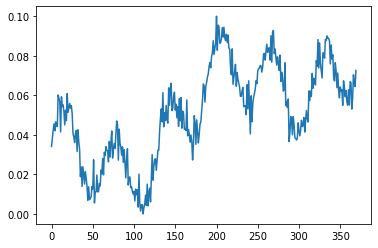

In [16]:
plt.plot(feat1)

In [0]:
y = 0.6 * feat1 + 0.2 * feat1.max() * np.sin(0.2 * np.arange(TIME_LEN)) + 0.05*feat1.max() *np.random.randn(TIME_LEN)
# y *= 100

In [0]:
y_scaler = MinMaxScaler((0, 0.1))

In [0]:
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

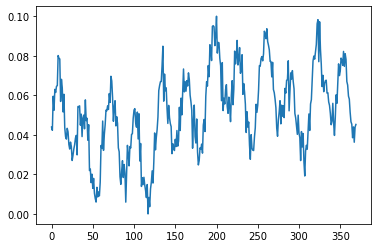

In [20]:
plt.plot(y)

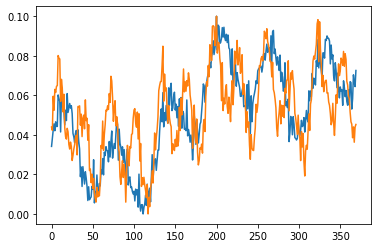

In [21]:
plt.plot(feat1)
plt.plot(y)

In [0]:
df = pd.DataFrame({
    'datetime': dts,
    'y': y,
    'feat1': feat1
})

In [0]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [0]:
df.set_index('datetime', inplace=True)

In [0]:
df['feat1_smooth'] = df['feat1'].rolling(10).mean()

In [0]:
df['y_smooth'] = df['y'].rolling(10).mean()

In [0]:
df.dropna(how='any', inplace=True)

In [0]:
ALPHA_D = 20

### feat単体予測モデル

In [0]:

class BILSTM(nn.Module):

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int
    ):
        super(BILSTM, self).__init__()
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        self._num_layers = num_layers
        self._output_dim = output_dim

        self._lstm = nn.LSTM(
            input_size=self._input_dim,
            hidden_size=self._hidden_dim,
            num_layers=self._num_layers,
            batch_first=True,
            bidirectional=True
        )

        self._linear = nn.Linear(
            self._hidden_dim*2,
            self._output_dim
        )

    def forward(self, x):
        self._lstm.flatten_parameters()
        out, hidden = self._lstm(x)
        return self._linear(out[:, :, :])

In [0]:

bilstm_feat = BILSTM(
    input_dim=1,
    hidden_dim=32,
    num_layers=2,
    output_dim=1
)

In [0]:
SEQ_LEN = 64

In [0]:
ALPHA_DAY = 60  # day
BETA_DAY = 90  # day

In [0]:
#NOW_DT = '2019-03-01'
NOW_DT = datetime.strptime('2019-04-01', '%Y-%m-%d')

In [0]:
ALPHA_DT = NOW_DT + timedelta(days=ALPHA_DAY)
BETA_DT = NOW_DT + timedelta(days=BETA_DAY)

In [0]:
df_feat_train = df[df.index < ALPHA_DT]
df_feat_test = df[df.index >= ALPHA_DT]

In [0]:
def create_train_dataset(train_data, seq_len):
    xs = []
    ys = []
    for t in range(len(train_data)-seq_len-1):
        mms = MinMaxScaler((-0.5, 0.5))
        x = mms.fit_transform(train_data[t:t+seq_len].reshape(-1, 1)).flatten()
        y = mms.transform(train_data[t+1:t+seq_len+1].reshape(-1, 1)).flatten()
        xs.append(torch.Tensor(x).view(seq_len, 1))
        ys.append(torch.Tensor(y).view(seq_len, 1))
    return torch.stack(xs, dim=0), torch.stack(ys, dim=0)

In [0]:
train_feat_xs, train_feat_ys = create_train_dataset(df_feat_train.feat1_smooth.to_numpy(), SEQ_LEN)

In [39]:
train_feat_xs.shape

torch.Size([198, 64, 1])

In [0]:
BATCH_SIZE = 8
EPOCHS = 100

In [0]:
mse_loss = nn.MSELoss()
optim_bilstm_feat = torch.optim.Adam(
    params=bilstm_feat.parameters(),
    lr=0.01
)

In [42]:
loss_history = []

for n in pb(range(EPOCHS)):
    losses = []
    for t in range(train_feat_xs.size(0) // BATCH_SIZE):
        x = train_feat_xs[t*BATCH_SIZE:(t+1)*BATCH_SIZE, :, :]
        y = train_feat_ys[t*BATCH_SIZE:(t+1)*BATCH_SIZE, :, :]

        out = bilstm_feat(x)
        loss = mse_loss(out, y)

        optim_bilstm_feat.zero_grad()
        loss.backward()
        optim_bilstm_feat.step()

        losses.append(loss.item())

    loss_history.append(sum(losses) / len(losses))

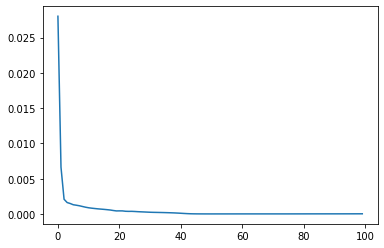

In [43]:
plt.plot(loss_history)

In [0]:
df['feat_pred'] = df['feat1']
df['feat_pred_smooth'] = df['feat1_smooth']

In [45]:
preds = []

x = df_feat_train.feat1_smooth.to_list()[-SEQ_LEN:]

# for t in pb(range(150)):
for t, dt in enumerate(pb(df_feat_test.index)):
    mms = MinMaxScaler((-0.5, 0.5))
    x_scaled = mms.fit_transform(np.array(x).reshape(-1, 1)).flatten().tolist()

    out = bilstm_feat(torch.Tensor(x_scaled).view(1, SEQ_LEN, train_feat_xs.shape[2]))
    preds.append(mms.inverse_transform(out[0, -1, 0].detach().numpy().reshape(-1, 1))[0][0])

    x = x[1:] + [preds[-1]]

    df.at[dt, 'feat_pred'] = preds[-1]
    df.at[dt, 'feat_pred_smooth'] = preds[-1]

In [46]:
df

,y,feat1,feat1_smooth,y_smooth,feat_pred,feat_pred_smooth
datetime,,,,,,
2018-09-10,0.078757,0.058353,0.045611,0.061097,0.058353,0.045611
2018-09-11,0.078391,0.056975,0.047893,0.064547,0.056975,0.047893
2018-09-12,0.056890,0.041463,0.048204,0.066006,0.041463,0.048204
2018-09-13,0.068092,0.059272,0.049896,0.066861,0.059272,0.049896
2018-09-14,0.063743,0.054339,0.050776,0.067991,0.054339,0.050776
...,...,...,...,...,...,...
2019-09-01,0.038537,0.058331,0.059615,0.059110,0.082475,0.082475
2019-09-02,0.044002,0.070356,0.060720,0.055407,0.082271,0.082271
2019-09-03,0.036271,0.066568,0.061133,0.051219,0.082085,0.082085


ERROR! Session/line number was not unique in database. History logging moved to new session 59


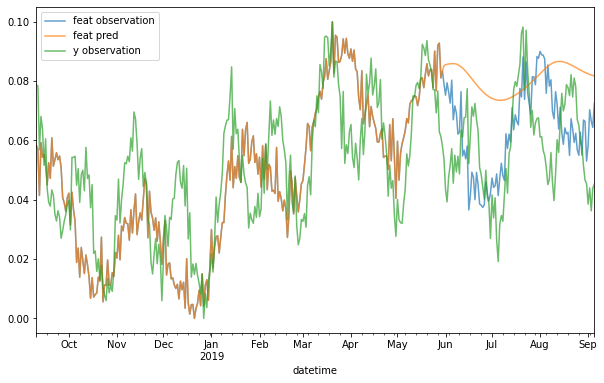

In [47]:
plt.figure(figsize=(10, 6))
df.feat1.plot(alpha=0.7, label='feat observation')
df.feat_pred.plot(alpha=0.7, label='feat pred')
df.y.plot(alpha=0.7, label='y observation')
plt.legend()

### feat実測値＋予測値とy実測値を用いたy予測モデル

In [0]:
df_y_train = df[df.index < NOW_DT]
df_y_test = df[df.index >= NOW_DT]

In [0]:
bilstm_y_feat = BILSTM(
    input_dim=2,
    hidden_dim=32,
    num_layers=2,
    output_dim=1
)

In [0]:
def create_y_feat_train_dataset(train_data, seq_len):
    xs = []
    ys = []
    for t in range(len(train_data)-seq_len-1):
        mms_x = MinMaxScaler((-0.5, 0.5))
        mms_y = MinMaxScaler((-0.5, 0.5))
        x = mms_x.fit_transform(train_data[t:t+seq_len, :].reshape(-1, 2)).reshape(seq_len, 2)
        y = mms_y.fit_transform(train_data[t+1:t+seq_len+1, 0].reshape(-1, 1)).flatten()
        xs.append(torch.Tensor(x).view(seq_len, 2))
        ys.append(torch.Tensor(y).view(seq_len, 1))
    return torch.stack(xs, dim=0), torch.stack(ys, dim=0)

In [52]:
df_y_train[['y_smooth', 'feat_pred']].values.shape

(203, 2)

In [0]:
xs, ys = create_y_feat_train_dataset(df_y_train[['y_smooth', 'feat_pred_smooth']].values, SEQ_LEN)

In [54]:
xs.shape

torch.Size([138, 64, 2])

In [55]:
ys.shape

torch.Size([138, 64, 1])

In [0]:
mse_loss = nn.MSELoss()
optim_bilstm_y_feat = torch.optim.Adam(
    params=bilstm_y_feat.parameters(),
    lr=0.01
)

In [57]:
loss_history = []

for n in pb(range(EPOCHS)):
    losses = []
    for t in range(xs.size(0) // BATCH_SIZE):
        x = xs[t*BATCH_SIZE:(t+1)*BATCH_SIZE, :, :]
        y = ys[t*BATCH_SIZE:(t+1)*BATCH_SIZE, :, :]

        out = bilstm_y_feat(x)
        loss = mse_loss(out, y)

        optim_bilstm_y_feat.zero_grad()
        loss.backward()
        optim_bilstm_y_feat.step()

        losses.append(loss.item())

    loss_history.append(sum(losses) / len(losses))

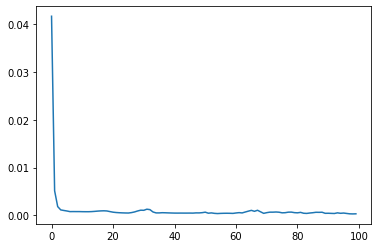

In [58]:
plt.plot(loss_history)

In [0]:
df['y_pred_with_feat'] = df['y_smooth']

In [60]:
preds = []

#x = df_y_train[['y', 'feat1']].values[-SEQ_LEN:].to_list()

# for t in pb(range(150)):
for t, dt in enumerate(pb(df_y_test.index)):
    x = df[df.index < dt][['y_pred_with_feat', 'feat_pred_smooth']].values[-SEQ_LEN:, :]

    mms_x = MinMaxScaler((-0.5, 0.5))
    mms_y = MinMaxScaler((-0.5, 0.5))
    x_scaled = mms_x.fit_transform(x.reshape(-1, 2)).reshape(SEQ_LEN, 2).tolist()
    mms_y.fit(x[:, 0].reshape(-1, 1))

    out = bilstm_y_feat(torch.Tensor(x_scaled).view(1, SEQ_LEN, 2))
    preds.append(mms_y.inverse_transform(out[0, -1, 0].detach().numpy().reshape(-1, 1))[0][0])

    #x = x[1:] + [preds[-1]]

    df.at[dt, 'y_pred_with_feat'] = preds[-1]

    # plt.plot(np.array(x_scaled)[:, 0])
    # plt.plot(np.array(x_scaled)[:, 1])
    # plt.show()

    # input()

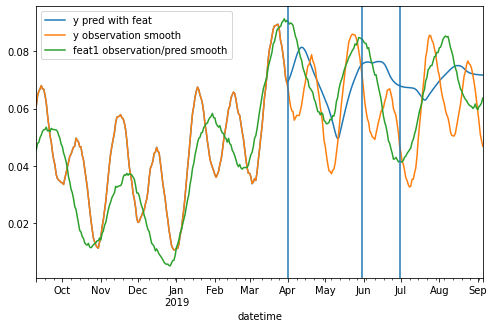

In [61]:
plt.figure(figsize=(8, 5))
df.y_pred_with_feat.plot(label='y pred with feat')
df.y_smooth.plot(label='y observation smooth')
df.feat1_smooth.plot(label='feat1 observation/pred smooth')
plt.axvline(NOW_DT, ymin=0, ymax=1)
plt.axvline(ALPHA_DT, ymin=0, ymax=1)
plt.axvline(BETA_DT, ymin=0, ymax=1)
plt.legend()

### y実測値のみを用いたy予測

In [0]:
bilstm_y = BILSTM(
    input_dim=1,
    hidden_dim=32,
    num_layers=2,
    output_dim=1
)

In [0]:
xs, ys = create_train_dataset(df_y_train[['y_smooth']].values, SEQ_LEN)

In [64]:
xs.shape

torch.Size([138, 64, 1])

In [65]:
ys.shape

torch.Size([138, 64, 1])

In [0]:
mse_loss = nn.MSELoss()
optim_bilstm_y = torch.optim.Adam(
    params=bilstm_y.parameters(),
    lr=0.01
)

In [67]:
loss_history = []

for n in pb(range(EPOCHS)):
    losses = []
    for t in range(xs.size(0) // BATCH_SIZE):
        x = xs[t*BATCH_SIZE:(t+1)*BATCH_SIZE, :, :]
        y = ys[t*BATCH_SIZE:(t+1)*BATCH_SIZE, :, :]

        out = bilstm_y(x)
        loss = mse_loss(out, y)

        optim_bilstm_y.zero_grad()
        loss.backward()
        optim_bilstm_y.step()

        losses.append(loss.item())

    loss_history.append(sum(losses) / len(losses))

In [0]:
df['y_pred_smooth'] = df['y_smooth']

In [69]:
preds = []

x = df_y_train.y_smooth.to_list()[-SEQ_LEN:]

# for t in pb(range(150)):
for t, dt in enumerate(pb(df_y_test.index)):
    mms = MinMaxScaler((-0.5, 0.5))
    x_scaled = mms.fit_transform(np.array(x).reshape(-1, 1)).flatten().tolist()

    out = bilstm_feat(torch.Tensor(x_scaled).view(1, SEQ_LEN, train_feat_xs.shape[2]))
    preds.append(mms.inverse_transform(out[0, -1, 0].detach().numpy().reshape(-1, 1))[0][0])

    x = x[1:] + [preds[-1]]

    df.at[dt, 'y_pred_smooth'] = preds[-1]

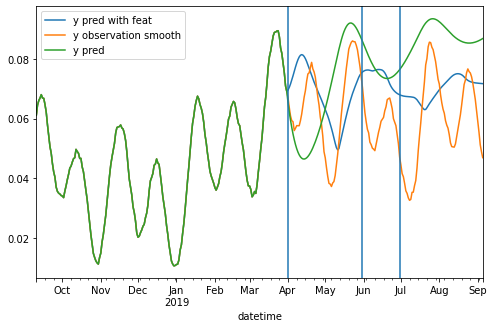

In [71]:
plt.figure(figsize=(8, 5))
df.y_pred_with_feat.plot(label='y pred with feat')
df.y_smooth.plot(label='y observation smooth')
# df.feat1_smooth.plot(label='feat1 observation/pred smooth')
df.y_pred_smooth.plot(label='y pred')
plt.axvline(NOW_DT, ymin=0, ymax=1)
plt.axvline(ALPHA_DT, ymin=0, ymax=1)
plt.axvline(BETA_DT, ymin=0, ymax=1)
plt.legend()